In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
def generate_quadratic(n, cond=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    Arand = np.random.rand(n, n)
    Asymm = 0.5 * (Arand + Arand.T)
    A = Asymm + n * np.eye(n)
    if cond is not None:
        U, S, Vt = np.linalg.svd(A)
        S_new = np.linspace(cond, 1, n)
        A = (U * S_new) @ Vt
        A = 0.5 * (A + A.T)
    b = np.random.randn(n)
    def f(x):
        return 0.5 * x @ (A @ x) - b @ x
    def grad(x):
        return A @ x - b
    x_star = np.linalg.solve(A, b)
    return A, b, f, grad, x_star

In [5]:
def gradient_descent(grad, x0, L, max_iter=1000, tol=1e-6):
    x = x0.copy()
    history = [x.copy()]
    for k in range(max_iter):
        g = grad(x)
        x -= (1/L) * g
        history.append(x.copy())
        if np.linalg.norm(g) < tol:
            break
    return np.array(history)

def heavy_ball(grad, x0, L, mu, beta, max_iter=1000, tol=1e-6):
    x_prev = x0.copy()
    x = x0.copy()
    history = [x.copy()]
    for k in range(max_iter):
        g = grad(x)
        x_new = x - (1/L)*g + beta*(x - x_prev)
        x_prev, x = x, x_new
        history.append(x.copy())
        if np.linalg.norm(g) < tol:
            break
    return np.array(history)

def nesterov_constant(grad, x0, L, mu, max_iter=1000, tol=1e-6):
    betta = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))
    x = x0.copy()
    y = x0.copy()
    history = [x.copy()]
    for k in range(max_iter):
        g = grad(y)
        x_new = y - (1/L) * g
        y = x_new + betta * (x_new - x)
        x = x_new
        history.append(x.copy())
        if np.linalg.norm(g) < tol:
            break
    return np.array(history)

def conjugate_gradient(A, b, x0, max_iter=None, tol=1e-6):
    if max_iter is None:
        max_iter = len(b)
    x = x0.copy()
    r = b - A @ x
    p = r.copy()
    history = [x.copy()]
    rs_old = r @ r
    for k in range(max_iter):
        Ap = A @ p
        alpha = rs_old / (p @ Ap)
        x += alpha * p
        r -= alpha * Ap
        rs_new = r @ r
        history.append(x.copy())
        if np.sqrt(rs_new) < tol:
            break
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new
    return np.array(history)


In [11]:
def task1(n, cond=None, seed=42, path=None):
    A, b, f, grad, x_star = generate_quadratic(n, cond, seed)
    L = np.linalg.eigvalsh(A).max()
    mu = np.linalg.eigvalsh(A).min()
    x0 = np.random.randn(n)

    hist_gd = gradient_descent(grad, x0, L)
    hist_hb = heavy_ball(grad, x0, L, mu, beta=(np.sqrt(L)-np.sqrt(mu))/(np.sqrt(L)+np.sqrt(mu)))
    hist_nes = nesterov_constant(grad, x0, L, mu)
    hist_cg = conjugate_gradient(A, b, x0)

    plt.figure(figsize=(6,4))
    for name, H in [("Град. спуск", hist_gd), ("Тяжелый шар", hist_hb), ("Нестеров", hist_nes), ("Сопряженные град.", hist_cg)]:
        errs = np.linalg.norm(H - x_star, axis=1)
        plt.semilogy(errs, label=name)
    # plt.title(f"Сходимость методов, n={n}, cond={cond}")
    plt.xlabel("Итерация k")
    plt.ylabel("||x_k − x*||")
    plt.legend()
    plt.grid(True)
    if path is not None:
        plt.savefig(path+f"task1_{n}_{cond}.png")
    plt.show()

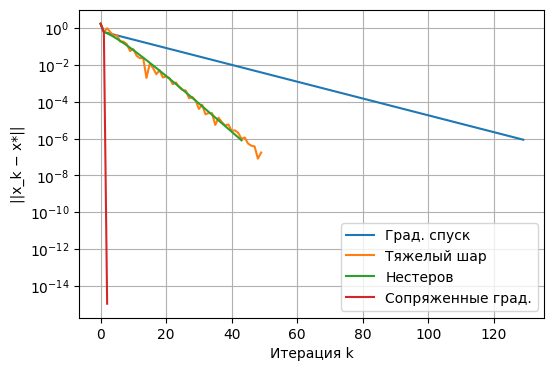

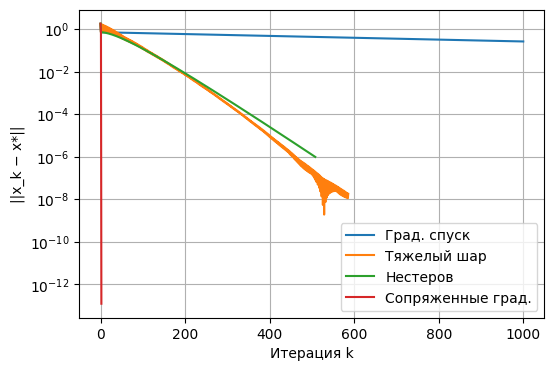

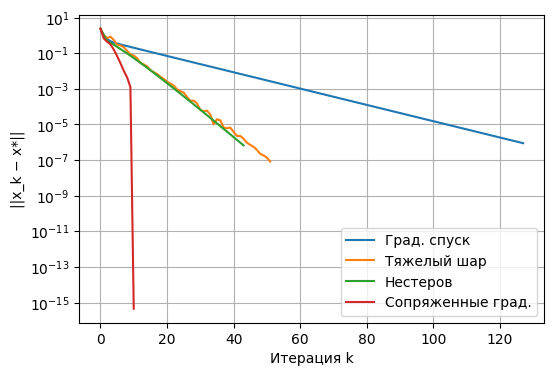

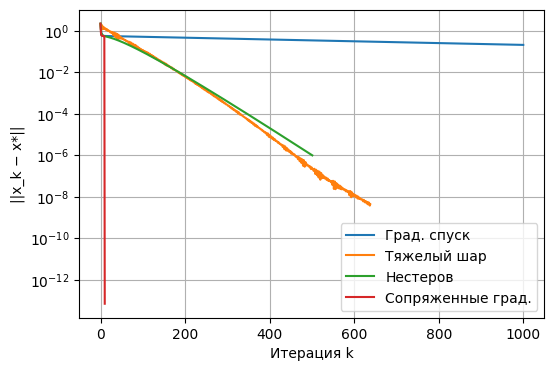

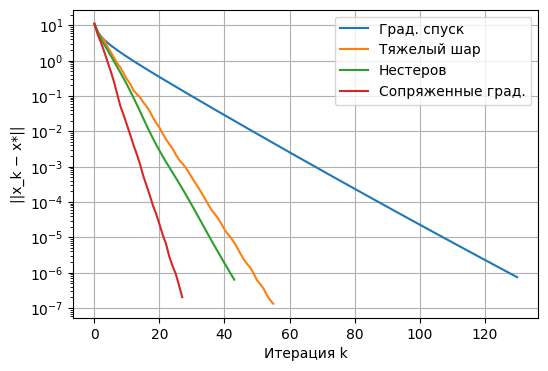

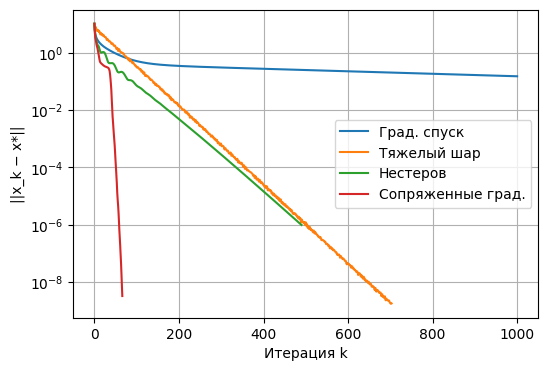

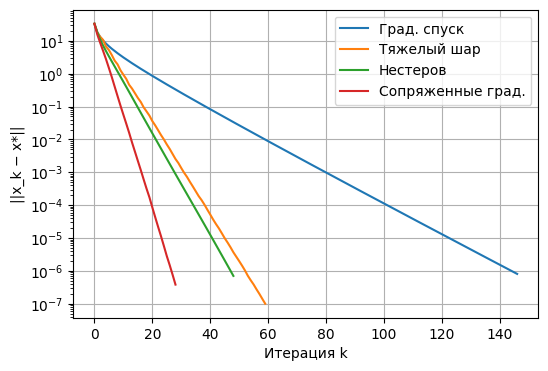

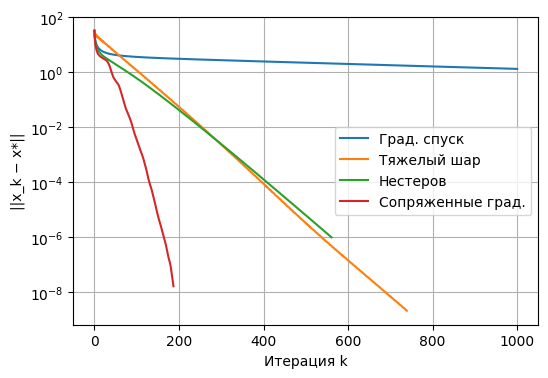

In [12]:
for n in [2, 10, 100, 1000]:
    task1(n, cond=10, path='images/')
    task1(n, cond=1000, path='images/')

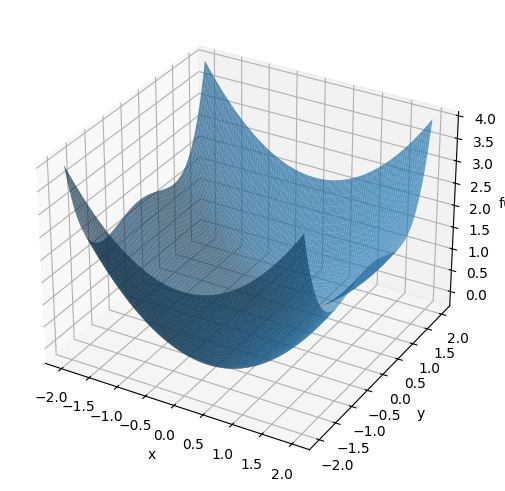

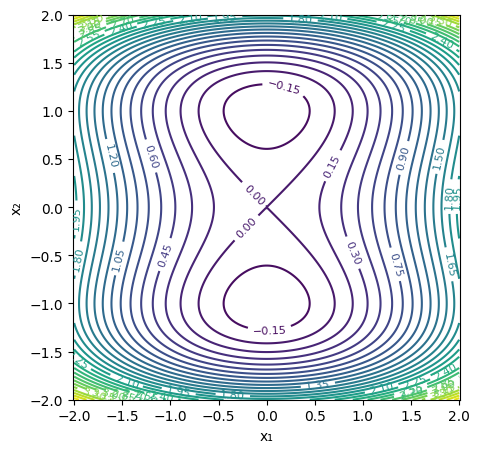

In [13]:
def f(x1, x2):
    return 0.5*x1**2 + 0.25*x2**4 - 0.5*x2**2

def grad(x):
    x1, x2 = x
    return np.array([x1, x2**3 - x2])


X = np.linspace(-2, 2, 200)
Y = np.linspace(-2, 2, 200)
Xg, Yg = np.meshgrid(X, Y)
Z = f(Xg, Yg)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xg, Yg, Z, alpha=0.7, rcount=100, ccount=100)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('f(x)')
plt.tight_layout()
plt.savefig('images/task2_surf.png')
plt.show()

plt.figure(figsize=(5,5))
cs = plt.contour(X, Y, Z, levels=30)
plt.clabel(cs, inline=1, fontsize=8)
plt.xlabel('x₁'); plt.ylabel('x₂')
plt.axis('equal')
plt.savefig('images/task2_min.png')
plt.show()


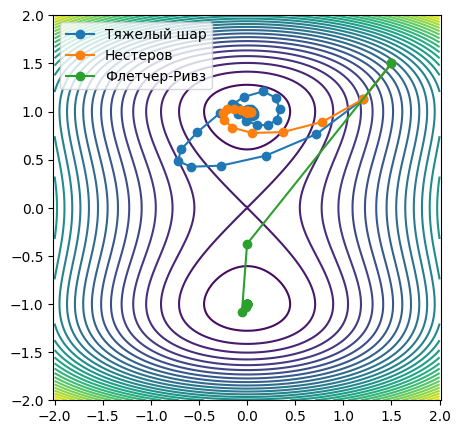

In [14]:
from scipy.optimize import line_search

def cg_fletcher_reeves(f, grad, x0, max_iter=1000, tol=1e-6):
    x = x0.copy()
    g = grad(x)
    p = -g
    history = [x.copy()]
    for k in range(1, max_iter+1):
        res = line_search(f, grad, x, p, g)
        alpha = res[0]  
        if alpha is None:
            alpha = 1e-3
        x = x + alpha*p
        g_new = grad(x)
        history.append(x.copy())
        if np.linalg.norm(g_new) < tol:
            break
        beta = (g_new @ g_new) / (g @ g)
        p = -g_new + beta*p
        g = g_new
    return np.array(history)


x0 = np.array([1.5, 1.5])

hist_hb = heavy_ball(lambda x: grad(x), x0, L=5, mu=0.1, beta=0.8)
hist_nes = nesterov_constant(lambda x: grad(x), x0, L=5, mu=0.1)
hist_fr = cg_fletcher_reeves(lambda x: f(*x), grad, x0)

plt.figure(figsize=(5,5))
plt.contour(X, Y, Z, levels=30)
for H, name in [(hist_hb, 'Тяжелый шар'), (hist_nes, 'Нестеров'), (hist_fr, 'Флетчер-Ривз')]:
    plt.plot(H[:,0], H[:,1], '-o', label=name)
plt.legend()
plt.axis('equal')
plt.savefig('images/task2_paths.png')
plt.show()


/tmp/ipykernel_51605/1793294970.py:8: RuntimeWarning: overflow encountered in scalar power
  -2*(1 - x1) - 400*x1*(x2 - x1**2),
/tmp/ipykernel_51605/1793294970.py:9: RuntimeWarning: overflow encountered in scalar power
  200*(x2 - x1**2)
/tmp/ipykernel_51605/818287117.py:33: RuntimeWarning: invalid value encountered in add
  y = x_new + betta * (x_new - x)
/tmp/ipykernel_51605/1793294970.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  -2*(1 - x1) - 400*x1*(x2 - x1**2),
/tmp/ipykernel_51605/1793294970.py:9: RuntimeWarning: invalid value encountered in scalar subtract
  200*(x2 - x1**2)


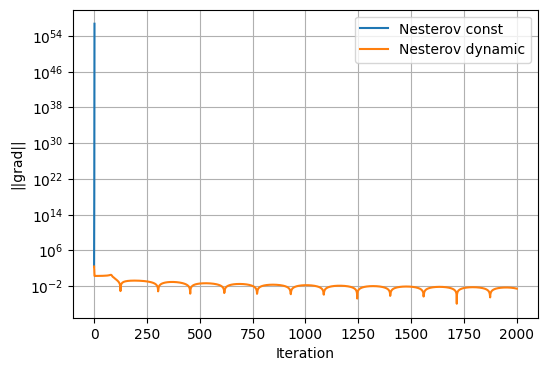

/tmp/ipykernel_51605/1793294970.py:39: LineSearchWarning: The line search algorithm did not converge
  res = line_search(f, grad, x, p, g)
/tmp/ipykernel_51605/1793294970.py:3: RuntimeWarning: overflow encountered in scalar power
  return (1 - x1)**2 + 100*(x2 - x1**2)**2
/tmp/ipykernel_51605/1793294970.py:45: RuntimeWarning: overflow encountered in matmul
  beta = (g_new @ g_new) / (g @ g)
/home/dinislam/study/.venv/lib/python3.13/site-packages/scipy/optimize/_linesearch.py:287: RuntimeWarning: invalid value encountered in multiply
  return f(xk + alpha * pk, *args)
/tmp/ipykernel_51605/1793294970.py:3: RuntimeWarning: invalid value encountered in scalar subtract
  return (1 - x1)**2 + 100*(x2 - x1**2)**2
/home/dinislam/study/.venv/lib/python3.13/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(


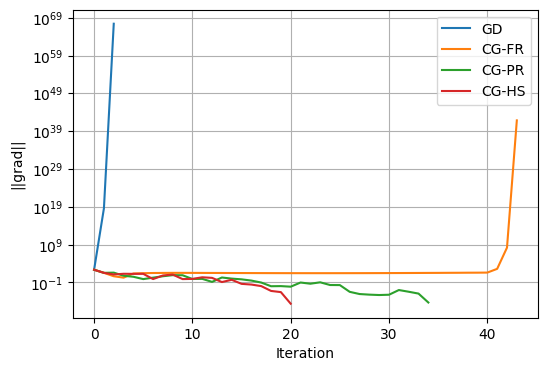

In [15]:
def rosenbrock(x):
    x1, x2 = x
    return (1 - x1)**2 + 100*(x2 - x1**2)**2

def grad_rosenbrock(x):
    x1, x2 = x
    return np.array([
        -2*(1 - x1) - 400*x1*(x2 - x1**2),
         200*(x2 - x1**2)
    ])

def nesterov_dynamic(grad, x0, alpha, max_iter=2000, tol=1e-6):
    x = x0.copy()
    y = x0.copy()
    t = 1.0
    history = [x.copy()]
    for _ in range(max_iter):
        g = grad(y)
        if np.linalg.norm(g) < tol:
            break
        x_new = y - alpha * g
        t_new = 0.5 * (1 + np.sqrt(1 + 4*t**2))
        beta = (t - 1) / t_new
        y = x_new + beta * (x_new - x)
        x, t = x_new, t_new
        history.append(x.copy())
    return np.array(history)

# 5) Нелинейный конъюгатный градиент: три варианта β
def cg_variant(f, grad, x0, variant='FR', max_iter=2000, tol=1e-6):
    x = x0.copy()
    g = grad(x)
    p = -g
    history = [x.copy()]
    for _ in range(max_iter):
        if np.linalg.norm(g) < tol:
            break
        # точный линейный поиск Wolfe
        res = line_search(f, grad, x, p, g)
        alpha = res[0] if res[0] is not None else 1e-3
        x_new = x + alpha * p
        g_new = grad(x_new)
        yk = g_new - g
        if variant == 'FR':
            beta = (g_new @ g_new) / (g @ g)
        elif variant == 'PR':
            beta = (g_new @ yk) / (g @ g)
        elif variant == 'HS':
            beta = (g_new @ yk) / (p @ yk)
        else:
            raise ValueError("Unknown CG variant")
        p = -g_new + beta * p
        x, g = x_new, g_new
        history.append(x.copy())
    return np.array(history)

# === Параметры эксперимента ===
x0 = np.array([-1.2, 1.0])
alpha = 1e-3
beta_const = 0.9

# === Сравнение Нестерова (пункт 2) ===
hist_nc = nesterov_constant(grad_rosenbrock, x0, alpha, beta_const)
hist_nd = nesterov_dynamic(grad_rosenbrock, x0, alpha)

plt.figure(figsize=(6,4))
for H, name in [(hist_nc, 'Nesterov const'), (hist_nd, 'Nesterov dynamic')]:
    norms = [np.linalg.norm(grad_rosenbrock(x)) for x in H]
    plt.semilogy(norms, label=name)
plt.xlabel('Iteration')
plt.ylabel('||grad||')
# plt.title('Rosenbrock: Nesterov const vs dynamic')
plt.legend()
plt.grid(True)
plt.savefig('images/task3_nesterov_comp.png')
plt.show()

# === Сравнение CG‑модификаций + GD (пункт 3) ===
hist_gd = gradient_descent(grad_rosenbrock, x0, alpha)
hist_fr = cg_variant(rosenbrock, grad_rosenbrock, x0, variant='FR')
hist_pr = cg_variant(rosenbrock, grad_rosenbrock, x0, variant='PR')
hist_hs = cg_variant(rosenbrock, grad_rosenbrock, x0, variant='HS')

plt.figure(figsize=(6,4))
for H, name in [
    (hist_gd, 'GD'),
    (hist_fr, 'CG-FR'),
    (hist_pr, 'CG-PR'),
    (hist_hs, 'CG-HS'),
]:
    norms = [np.linalg.norm(grad_rosenbrock(x)) for x in H]
    plt.semilogy(norms, label=name)
plt.xlabel('Iteration')
plt.ylabel('||grad||')
# plt.title('Rosenbrock: GD vs CG variants')
plt.legend()
plt.grid(True)
plt.savefig('images/task3_cg_variants.png')
plt.show()